<a href="https://colab.research.google.com/github/timmmariya/Empirical-Law-Studies/blob/main/4_%D0%9C%D0%B0%D1%82%D1%80%D0%B8%D1%86%D0%B0_%D0%BF%D1%80%D0%BE%D0%B2%D0%B5%D1%80%D0%BA%D0%B8_%D0%93%D0%B8%D0%BF%D0%BE%D1%82%D0%B5%D0%B7%D1%8B_%D0%BE_%D1%80%D0%B0%D0%B2%D0%B5%D0%BD%D1%81%D1%82%D0%B2%D0%B5_%D1%81%D1%80%D0%B5%D0%B4%D0%BD%D0%B8%D1%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Представленный Colab Notebook является частью серии наработок по исследованиям в области практической оценки судопроизводства методами численного анализа, проводимых [НУЛ анализа данных правоприменения НИУ ВШЭ](https://adp.hse.ru/). 

Контактная информация рабочей группы: gkrasnozhenov@hse.ru (Григорий Григорьевич Красноженов, ЗавЛаб НУЛ АДП), timmariya541@gmail.com (Мария Тимонина, стажер, ответственный за текущую задачу)

Материалом для анализа служат **данные системы арбитражных судов РФ**.

---

#### Стандартный пролог

подключение библиотек и загрузка данных SQL-базы в pandas dataFrame

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

plt.style.use('ggplot') # стиль графиков
import seaborn as sns
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/НУЛ АДП Материалы Марии Тимониной/_data/twenty_years_base/2015_2020_cleaned_dates.csv"
df = pd.read_csv(path, sep=',')

In [ ]:
df['StartDate'] = pd.to_datetime(df['StartDate'])
df['FinishDate'] = pd.to_datetime(df['FinishDate'])

In [ ]:
def q25(x) :
  return x.quantile(0.25)

def q75(x) :
  return x.quantile(0.75)

### Общий вид базы

In [ ]:
df.head()

,StartDate,FinishDate,ConsidTime,CourtID,CategoryID
0,2016-04-19,2016-08-15,118,50,77
1,2017-11-10,2018-05-28,199,41,20
2,2015-12-18,2016-08-03,229,62,4
3,2020-06-23,2020-10-16,115,43,151
4,2015-11-25,2016-01-28,64,65,4


In [ ]:
df = df[df['CategoryID'] < 203]

# **Описание задачи**

На более ранних этапах исследования осуществлена первичная очистка данных. Введенна классификация по списку значимых признаков. Подробнее: [предыдущий Colab Notebook](https://colab.research.google.com/drive/123fHdRPJFeiOs8FFUWg7PaFdr99uUVHu?usp=sharing)


Производится проверка Гипотезы о равенстве математических ожиданий двух произвольных распределений по выборкам большого размера (средних) попарно для выборок дел из различных категорий/судов Катотеки арбитражных дел (КАД).

Выдвигается **гипотеза** $H_0: E(X) = E(Y)$. В качестве альтернативной гипотезы рассматривается $H_1: E(X) \neq E(Y)$.

Обозначим за $(x_1, \ldots, x_n)$,  $(y_1, \ldots, y_m)$ элементы выборок из генеральных совокупностей $X$ и $Y$. Центральная предельная теорема утверждает, разность выборочных средних $(\overline{X_{выб}} - \overline{Y_{выб}})$ распределена по закону, близкому к нормальному.

При больших $n$ и $m$ выборочные дисперсии являются достаточно хорошими оценкам теоретических дисперсий. По свойствам дисперсии $D(\overline{X_{выб}} - \overline{Y_{выб}}) = 
\dfrac{nD(X_1)}{n^2} + \dfrac{mD(Y)}{m^2} = \dfrac{\sigma_X^2}{n} + \dfrac{\sigma_Y^2}{m}$. 

Если $H_0$ не отвергается, то  $E(\overline{X_{выб}} - \overline{Y_{выб}}) = 0$, поэтому случайная величина $K$ распределена по закону, близкому к нормальному $N(0, 1)$, и будет использоваться в качестве критерия для проверки $H_0$.

$$ K = \dfrac{\overline{X_{выб}} - \overline{Y_{выб}}}{\sqrt{\dfrac{d_{X,выб}^2}{n} + \dfrac{d_{Y,выб}^2}{m}}}$$

---


In [ ]:
def K_value(categ1, categ2, df_work) :
    mean1 = df_work.at[categ1, 'mean']
    mean2 = df_work.at[categ2, 'mean']

    std1 = df_work.at[categ1, 'std']
    std2 = df_work.at[categ2, 'std']

    n1 = df_work.at[categ1, 'count']
    n2 = df_work.at[categ2, 'count']

    k = (mean1 - mean2) / np.sqrt(std1 * std1 / n1 + std2 * std2 / n2)
    return k

**Построение критических областей**

Используется двусторонняя критическая область, состоящая из двух интервалов $(-\infty; X_{left, \alpha/2} := A)$ и $(X_{right, \alpha/2} := B; +\infty)$, где критические точки определяются из условия:
$$ P(N(0,1) <  A) = \dfrac{\alpha}{2}, P(N(0,1) >  B) = \dfrac{\alpha}{2}$$

Если вычисленное по выборке значение критерия $K$ попадает на отрезок $(A, B)$, то рассматривается гипотеза $H_0$. Если же оно принадлежит одному из двух крайних интервалов, то гипотеза отвергается на уровне значимости $\alpha$, уступая $H_1$. 

Поскольку плотность стандартного нормального распределения симметрична относительно нуля, про точки А и В известно, что $B = -A$. Гипотеза не отвергается с надежностью $(1 - \alpha)$, когда:

$$ P(A < N(0,1) <  B) = F(B) - F(-B) = 2F(B) = (1 - \alpha),  \quad\quad \Rightarrow \quad\quad F(B) = P(N(0,1) <  B) = \dfrac{(1 - \alpha)}{2} $$



# **Алгоритм разыменования кодировки названий**

In [ ]:
pathc = "/content/drive/MyDrive/НУЛ АДП Материалы Марии Тимониной/_data/indexed_categories.csv"
df_categs = pd.read_csv(pathc, sep=',')
df_categs.tail()

,ID,ancestorID,сCode,Descr,typeID
200,201,200,55.1,Споры по дела об оспаривании ненормативных пра...,8
201,202,200,55.2,Споры по делам об оспаривании ненормативных пр...,8
202,203,0,56,Экономические споры между Российской Федерацие...,8
203,204,0,57,Экономические споры между субъектами Российско...,8
204,205,0,Нет,Нет,8


In [ ]:
df_categs.to_excel("/content/drive/MyDrive/НУЛ АДП Материалы Марии Тимониной/_data/indexed_categories.xlsx")

Создается словарь `id_descr`, хранящий полные названия категорий в строковом виде по его ключу-индексу в сквозной нумерации системы хранения. Используется метод `.map(dict)` для замены значений столбца по парам из словаря.

In [ ]:
id_descr = df_categs[['ID', 'Descr']].set_index('ID').to_dict()['Descr']

In [ ]:
pathc = "/content/drive/MyDrive/НУЛ АДП Материалы Марии Тимониной/_data/indexed_courts.csv"
df_courts = pd.read_csv(pathc, sep=',')
df_courts.tail()

,ID,Ccode,Cname,Caltname,Calt2name,CTypeID,IDupperCourt,DistrID
113,309,Ф09,АС Уральского округа,АС УО,--,3,401,9
114,310,Ф10,АС Центрального округа,АС ЦО,--,3,401,10
115,400,ВАС,Высший Арбитражный Суд РФ,ВАС РФ,--,4,400,0
116,401,ВС,Верховный Суд РФ,ВС РФ,--,4,400,0
117,500,СИП,Суд по интеллектуальным правам,СИП,--,5,400,0


In [ ]:
ic_cname = df_courts[['ID', 'Cname']].set_index('ID').to_dict()['Cname']

# **Реализация**

Используется генератор **Нормального распределения** из встроенной библиотеки `scipy.stats`, $X \sim N(0, 1)$, плотность которого выглядит как: $
\rho(x) = \frac{1}{\sqrt{2 \pi}} \cdot  e^{-\frac{x^2}{2}}
$

Параметр ```loc``` задаёт $\mu$, ```scale``` — среднеквадратичное отклонение $\sigma$ в $N(\mu, \sigma)$.

In [ ]:
def norm_distr_quantiles(alpha) :
    norm_rv = stats.norm(loc=0, scale=1)  # задали генератор 
    sample = norm_rv.rvs(1000)  # сгенерируем 1000 значений

    gamma = 1 - alpha / 2

    q_right = norm_rv.ppf(gamma)
    q_left = (-1) * q_right
    return gamma, q_left, q_right

In [ ]:
print(norm_distr_quantiles(0.02))

(0.99, -2.3263478740408408, 2.3263478740408408)


Как было установлено ранее, для уровня значимости $\alpha$ гипотеза не отвергается, если рассчитываемое значение показателя $K$ лежит в границах интервала $(X_{left, \alpha/2}, X_{right, \alpha/2})$, где эти крайние точки определяются как  квантиль уровня $\frac{(1 - \alpha)}{2}$ и число, равное ему по модулю и обратное по знаку.

Квантиль уровня $\gamma$ это такое число $q$, что $P(X \le q) = \gamma$. В python его можно получить с помощью метода `.ppf(`$\gamma$).

---
---

## **Первая идея с сортировкой категорий по частоте совпадений**

Реализована функция, принимающая на вход два массива граничных дат анализируемых временных интервалов (стандартно рассматривается 1 месяц, но возможно задать период произвольной длины) длины N и уровень значимости.

 Она отрисовывает N симметрических матриц удовлетворения условию , где желтая клетка (i, j) обозначает, что для пары категорий i и j гипотеза не отвергается, а фиолетовая наоборот - отвергается на уровне значимости $\alpha$.

In [ ]:
def pairwise_hypothesis_test_arr(left_border_dates, right_border_dates, alpha=0.05, min_count=100, fs=10) :
    if (len(left_border_dates) != len(right_border_dates)) :
        print("Length of left_border_dates does not match the right_border_dates length!")
        return

    fig, ax = plt.subplots(nrows=2, ncols=len(left_border_dates), figsize=(len(left_border_dates) * fs, 2 * fs))
    arr_fits = [[] for i in range(len(left_border_dates))]
    for dd in range(len(left_border_dates)) :
          # отбор из полной базы всех дел за период от левой граничной даты до правой
          df_parse = df[(df['StartDate'] <= pd.to_datetime(right_border_dates[dd])) & (df['FinishDate'] >= pd.to_datetime(left_border_dates[dd]))]
          # подсчет средних, стандартных отклонений, кол-ва дел для каждой из категорий -> сохранение в dataframe df_work
          df_work = df_parse.groupby('CategoryID')['ConsidTime'].agg(['mean', 'std', 'count'])
          # рассматриваются только состоятельные категории, содержащие не менее min_count дел
          df_work = df_work[df_work['count'] > min_count]

          categ_list = df_work.index
          cnum = len(categ_list)

          # Подсчет значения критерия К для всех пар категорий
          kdata = [[0] * cnum for i in range(cnum)]
          for i in range(cnum) :
              for j in range(cnum) :
                  kdata[i][j] = K_value(categ_list[i], categ_list[j], df_work)
          df_kcrit = pd.DataFrame(kdata, index=range(cnum), columns=range(cnum))

          # определение границ доверительного интервала
          gamma, q_left, q_right = norm_distr_quantiles(alpha)
          # проверка гипотезы о равенстве средних для каждой пары
          hy_data = [[0] * cnum for i in range(cnum)]
          for i in range(cnum) :
              for j in range(cnum) :
                  if (kdata[i][j] > q_left) and (kdata[i][j] < q_right) :
                      hy_data[i][j] = 1
                  else :
                      hy_data[i][j] = 0
          df_hypo = pd.DataFrame(hy_data, index=range(cnum), columns=range(cnum))

          fits = []
          for i in range(cnum) :
              sum = 0
              for j in range(cnum) :
                  sum += hy_data[i][j]
              fits.append(sum)

          arr_fits[dd] = pd.DataFrame([categ_list, fits]).transpose()
          # далее идет код к построению второй матрицы - сортировка категорий
          
          df_work['fits'] = fits
          df_work = df_work.sort_values(by='fits', ascending=False)

          categ_list = df_work.index
          cnum = len(categ_list)

          kdata = [[0] * cnum for i in range(cnum)]
          for i in range(cnum) :
              for j in range(cnum) :
                  kdata[i][j] = K_value(categ_list[i], categ_list[j], df_work)

          hy_data_s = [[0] * cnum for i in range(cnum)]
          for i in range(cnum) :
              for j in range(cnum) :
                  if (kdata[i][j] > q_left) and (kdata[i][j] < q_right) :
                      hy_data_s[i][j] = 1
                  else :
                      hy_data_s[i][j] = 0    

          df_hypo_s = pd.DataFrame(hy_data_s, index=range(cnum), columns=range(cnum))
          
          sns.heatmap(df_hypo, square=True, ax=ax[0][dd], cmap="flare_r")
          sns.heatmap(df_hypo_s, square=True, ax=ax[1][dd], cmap="flare_r")

    return arr_fits

**Комментарии к результату работы функции** 

Результат отображается в двух представлениях (двух строках таблицы матриц): в верхней полосе строки и столбцы категорий отсортированы по возрастанию своего номера в иерархической системе. Для увеличения наглядности и поиска возможных устойчивых соотоншений во второй полосе под каждым графиком из верхней строки изображается матрица, составленная из тех же ответов да/нет проверки гипотезы, но категории отсортированы по убыванию количества удовлетворительных ответов для одной категории. 

В данный момент в тетрадке подгружается полная база **Картотеки арбитражных дел РФ с 2015 по 2020 год** включительно. Изобразим матрицы проверки гипотезы для января, мая, августа и декабря каждого из пяти лет.

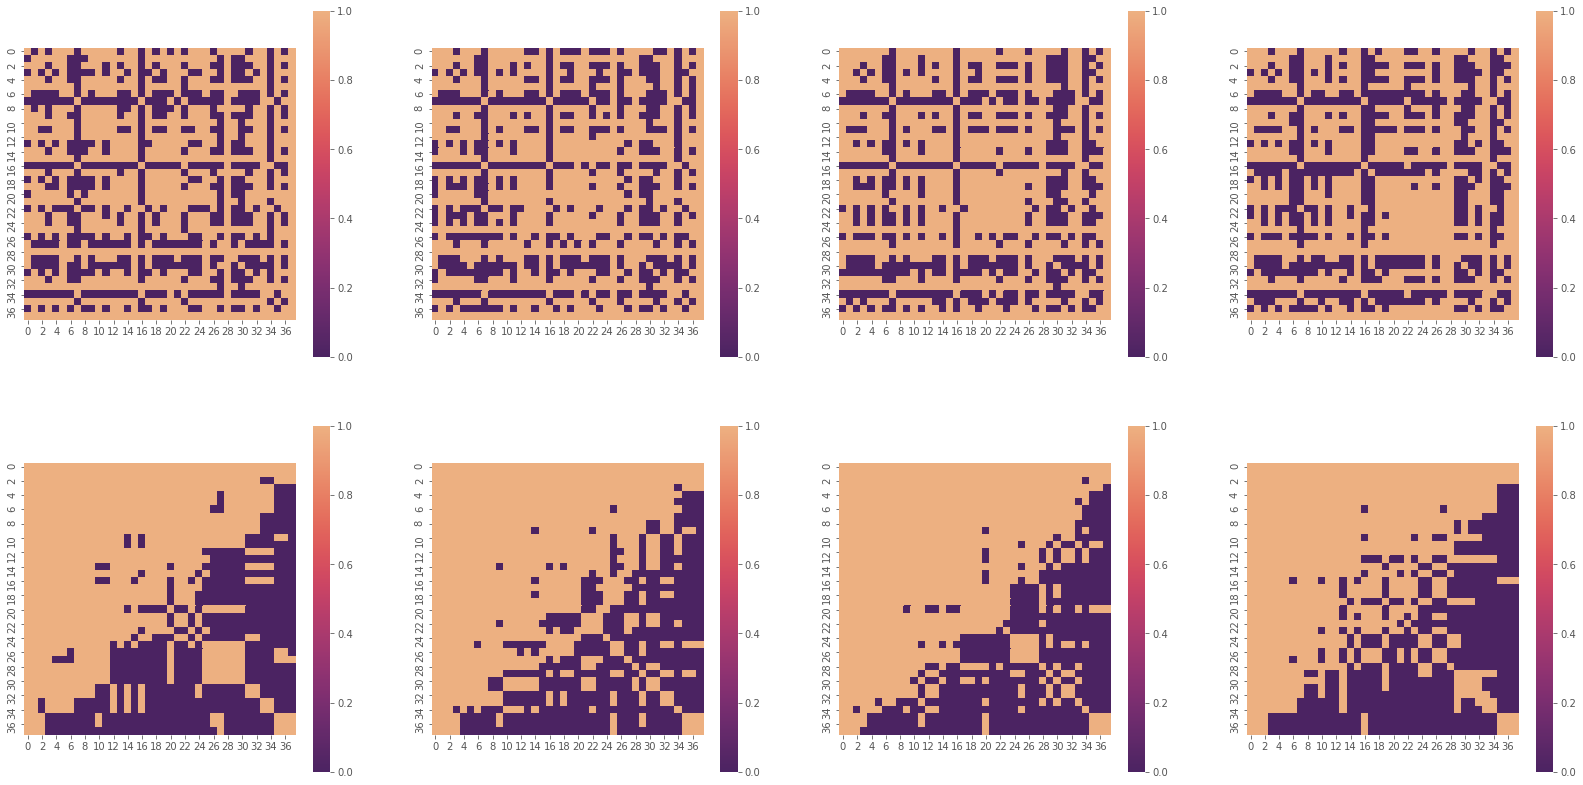

In [ ]:
lb = ['2015-01-01', '2015-05-01', '2015-08-01', '2015-12-01']
rb = ['2015-01-31', '2015-05-31', '2015-08-31', '2015-12-31']
list_dfcs = pairwise_hypothesis_test_arr(lb, rb, alpha=0.02, min_count=2, fs=7)

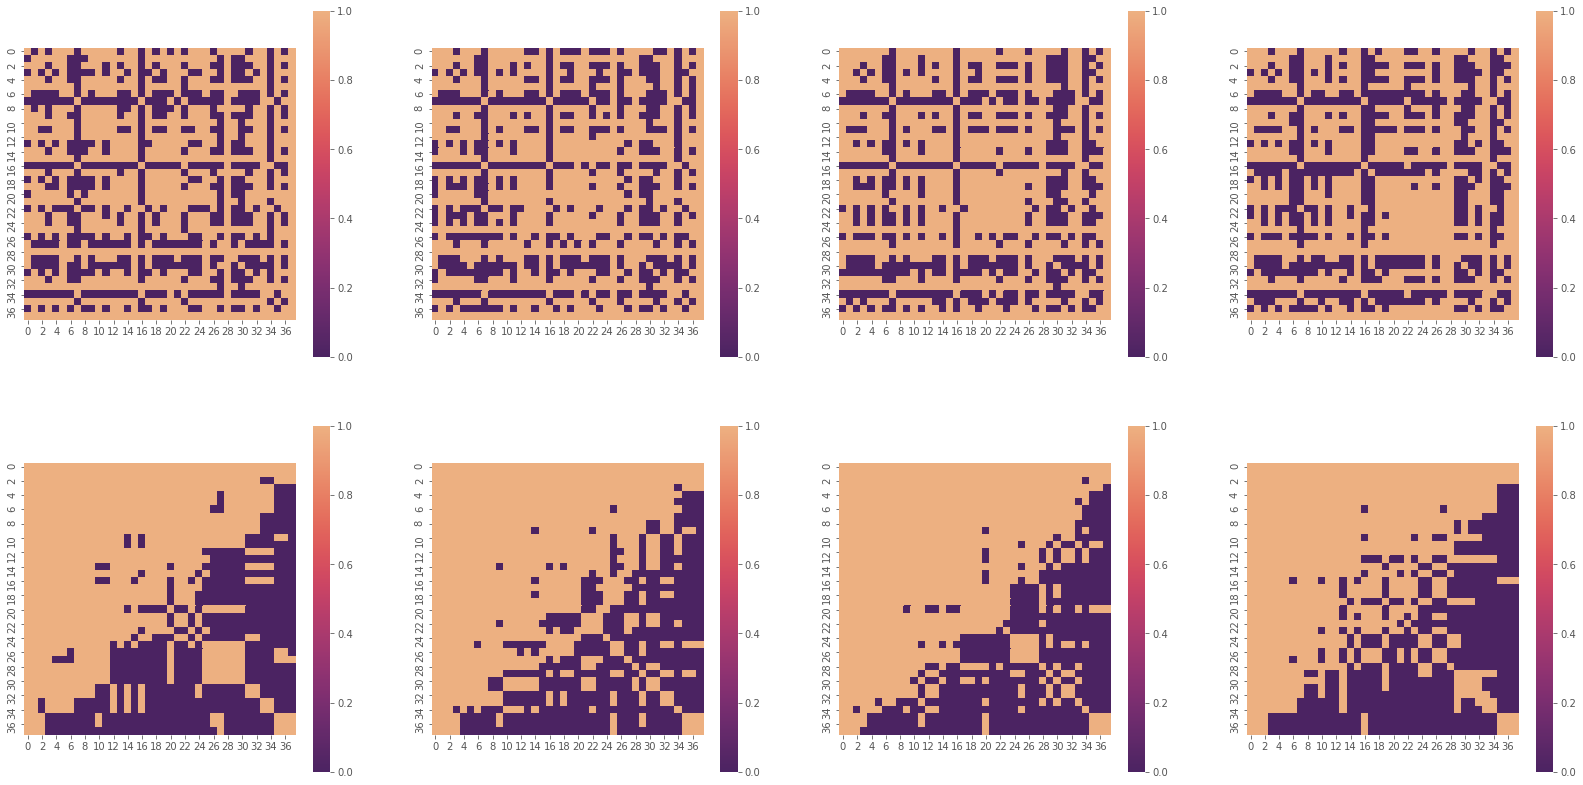

In [ ]:
lb = ['2015-01-01', '2015-05-01', '2015-08-01', '2015-12-01']
rb = ['2015-01-31', '2015-05-31', '2015-08-31', '2015-12-31']
list_dfcs = pairwise_hypothesis_test_arr(lb, rb, alpha=0.02, min_count=2, fs=7)

## **Обработка информации о кол-ве совпадений для группы матриц**

Чтобы осмыслить полученные результаты, нужно установить, какие категории имеют "наиболее стандартные" распределения, то есть гипотеза о равенстве средних не отвергается для них с самым большим числом других категорий в паре, и наоборот - названия категорий, показывающих меньше всего желтых клеток в матрицах.

Более того, можно попробовать объяснить схожесть для групп категорий их принадлежностью к категориям, более близким друг к другу по содержанию дел или видам договоров, если такая кластеризация имеет место быть.

In [ ]:
main_cmet = df.groupby('CategoryID')['ConsidTime'].agg(['count']).index.to_list()

In [ ]:
ctotal = len(main_cmet)

def pairwise_hypothesis_test_filled(left_border_date, right_border_date, dest, alpha=0.05, min_count=0, fs=10, axi=False) :

    if axi == False:
      fig, axi = plt.subplots(figsize=(fs, fs))

    # отбор из полной базы всех дел за период от левой граничной даты до правой
    df_parse = df[(df['StartDate'] <= pd.to_datetime(right_border_date)) & (df['FinishDate'] >= pd.to_datetime(left_border_date))]
    # подсчет средних, стандартных отклонений, кол-ва дел для каждой из категорий -> сохранение в dataframe df_work
    df_work = df_parse.groupby('CategoryID')['ConsidTime'].agg(['mean', 'std', 'count'])
    # рассматриваются только состоятельные категории, содержащие не менее min_count дел
    df_work = df_work[df_work['count'] > min_count]

    categ_list_used = df_work.index
    cnum = len(categ_list_used)

    useid = [0 for i in range(cnum)]
    p = 0
    for i in range(cnum) :
        while (main_cmet[p] < categ_list_used[i]) :
          p += 1
        useid[i] = p
        p += 1

    # Подсчет значения критерия К для всех пар категорий
    kdata = [[0] * ctotal for i in range(ctotal)]
    for i in range(cnum) :
        for j in range(cnum) :
            ii = useid[i]
            jj = useid[j]
            kdata[ii][jj] = K_value(categ_list_used[i], categ_list_used[j], df_work)
    df_kcrit = pd.DataFrame(kdata, index=range(ctotal), columns=range(ctotal))

    # определение границ доверительного интервала
    gamma, q_left, q_right = norm_distr_quantiles(alpha)
    # проверка гипотезы о равенстве средних для каждой пары
    hy_data = [[2] * ctotal for i in range(ctotal)]
    for i in range(cnum) :
        for j in range(cnum) :
            ii = useid[i]
            jj = useid[j]
            if (kdata[ii][jj] > q_left) and (kdata[ii][jj] < q_right) :
                hy_data[ii][jj] = 1
            else :
              hy_data[ii][jj] = 0
    df_hypo = pd.DataFrame(hy_data, index=range(ctotal), columns=range(ctotal))

    fits = [0 for i in range(ctotal)]
    for i in range(cnum) :
        sum = 0
        for j in range(cnum) :
            ii = useid[i]
            jj = useid[j]
            sum += hy_data[ii][jj]
        fits[useid[i]] = sum
    dest[left_border_date] = fits

    sns.heatmap(df_hypo, square=True, ax=axi, cbar=False)

,2015-01-01,2015-05-01,2015-08-01,2015-12-01
max,38.000000,38.000000,38.000000,38.000000
min,7.000000,8.000000,7.000000,7.000000
q25,19.000000,20.250000,21.000000,19.000000
q75,32.500000,31.750000,32.750000,29.750000
mean,24.105263,25.052632,25.210526,23.631579


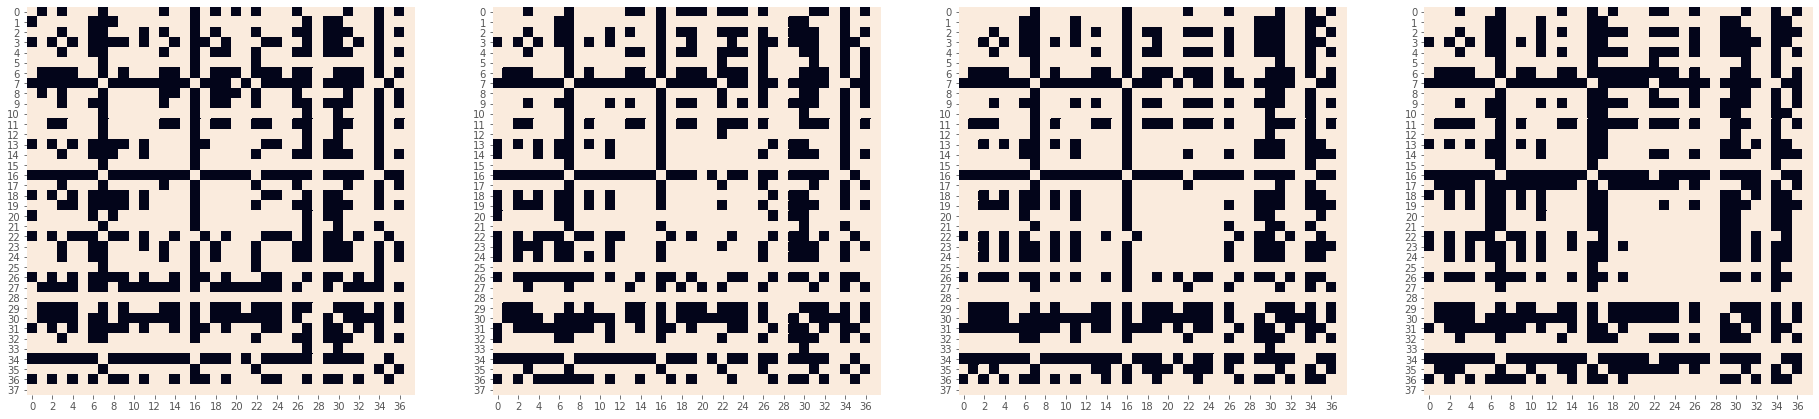

In [ ]:
lb = ['2015-01-01', '2015-05-01', '2015-08-01', '2015-12-01']
rb = ['2015-01-31', '2015-05-31', '2015-08-31', '2015-12-31']

fs = 8
fig, ax = plt.subplots(ncols = len(lb), figsize=( len(lb) * fs, fs))

id_2015 = pd.DataFrame([main_cmet]).transpose()
id_2015.rename(columns={0 : 'Categ'}, inplace=True)

for i in range(len(lb)) :
    pairwise_hypothesis_test_filled(lb[i], rb[i], id_2015, alpha=0.02, axi=ax[i])

id_2015.set_index('Categ', inplace=True)
id_2015.agg(['max', 'min', q25, q75, 'mean'])

In [ ]:
id_2015['Categ'] = id_2015.index.map(id_descr)

id_2015.sort_values(by='2015-05-01', ascending=True, inplace=True)
id_2015['Categ'].values[:10]

array(['Споры о неисполнении или ненадлежащем исполнении обязательств по договорам займа и кредита',
       'Споры о несостоятельности (банкротстве)',
       'Споры, связанные с защитой права собственности, иных вещных прав',
       'Споры, связанные с применением законодательства об административных правонарушениях',
       'Споры о взыскании с организаций и граждан обязательных платежей и санкций, если не предусмотрен иной порядок их взыскания',
       'Споры, связанные с применением законодательства о земле',
       'Споры о неисполнении или ненадлежащем исполнении обязательств по договорам в сфере транспортной деятельности',
       'Споры об оспаривании ненормативных правовых актов, решений и действий (бездействия) государственных органов, органов местного самоуправления, иных органов, организаций, наделенных федеральным законом отдельными государственными или иными публичными полномочиями, должностных лиц',
       'Споры о выдаче исполнительного листа на принудительное исполнение 

,2019-01-01,2019-05-01,2019-08-01,2019-12-01
max,37.000000,38.000000,38.000000,36.000000
min,0.000000,2.000000,2.000000,0.000000
q25,17.250000,18.250000,19.000000,17.250000
q75,28.250000,29.750000,28.000000,26.000000
mean,21.078947,22.263158,22.473684,19.973684


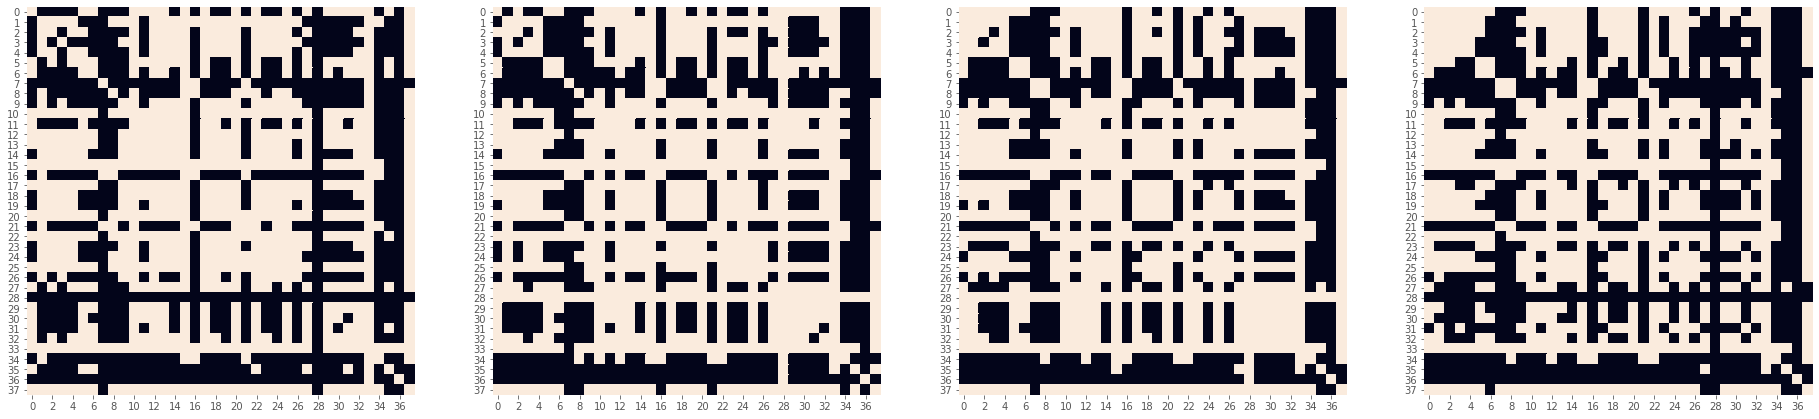

In [ ]:
lb = ['2019-01-01', '2019-05-01', '2019-08-01', '2019-12-01']
rb = ['2019-01-31', '2019-05-31', '2019-08-31', '2019-12-31']

fs = 8
fig, ax = plt.subplots(ncols = len(lb), figsize=( len(lb) * fs, fs))

id_2019 = pd.DataFrame([main_cmet]).transpose()
id_2019.rename(columns={0 : 'Categ'}, inplace=True)

for i in range(len(lb)) :
    pairwise_hypothesis_test_filled(lb[i], rb[i], id_2019, alpha=0.02, axi=ax[i])

id_2019.set_index('Categ', inplace=True)
id_2019.agg(['max', 'min', q25, q75, 'mean'])

In [ ]:
id_2019['Categ'] = id_2019.index.map(id_descr)

id_2019.sort_values(by='2019-08-01', ascending=True, inplace=True)

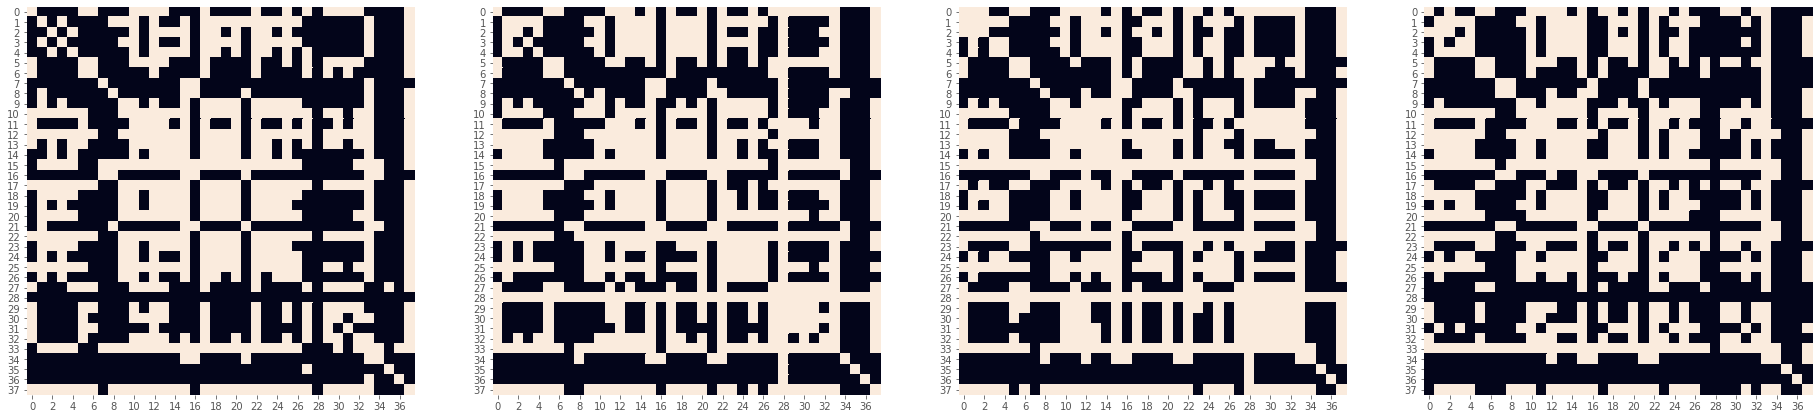

In [ ]:
lb = ['2019-01-01', '2019-05-01', '2019-08-01', '2019-12-01']
rb = ['2019-01-31', '2019-05-31', '2019-08-31', '2019-12-31']

fs = 8
fig, ax = plt.subplots(ncols = len(lb), figsize=( len(lb) * fs, fs))

table_2019_5 = pd.DataFrame([main_cmet]).transpose()
table_2019_5.rename(columns={0 : 'Categ'}, inplace=True)

for i in range(len(lb)) :
    pairwise_hypothesis_test_filled(lb[i], rb[i], table_2019_5, alpha=0.1, axi=ax[i])

#table_2019_5.head()

## **Базовое деление - территориальное (по судам)**

In [ ]:
courts_met = df.groupby('CourtID')['ConsidTime'].agg(['count']).index.to_list()
len(courts_met)

84

In [ ]:
courtot = len(courts_met)

def pairwise_hypothesis_test_courts(left_border_date, right_border_date, dest, alpha=0.05, min_count=0, fs=15, axi=False, df=df) :

    if axi == False:
      fig, axi = plt.subplots(figsize=(fs, fs))

    # отбор из полной базы всех дел за период от левой граничной даты до правой
    df_parse = df[(df['StartDate'] <= pd.to_datetime(right_border_date)) & (df['FinishDate'] >= pd.to_datetime(left_border_date))]
    # подсчет средних, стандартных отклонений, кол-ва дел для каждой из категорий -> сохранение в dataframe df_work
    df_work = df_parse.groupby('CourtID')['ConsidTime'].agg(['mean', 'std', 'count'])
    # рассматриваются только состоятельные категории, содержащие не менее min_count дел
    df_work = df_work[df_work['count'] > min_count]

    court_list_used = df_work.index
    cnum = len(court_list_used)

    useid = [0 for i in range(cnum)]
    p = 0
    for i in range(cnum) :
        while (courts_met[p] < court_list_used[i]) :
          p += 1
        useid[i] = p
        p += 1

    # Подсчет значения критерия К для всех пар категорий
    kdata = [[0] * courtot for i in range(courtot)]
    for i in range(cnum) :
        for j in range(cnum) :
            ii = useid[i]
            jj = useid[j]
            kdata[ii][jj] = K_value(court_list_used[i], court_list_used[j], df_work)
    df_kcrit = pd.DataFrame(kdata, index=range(courtot), columns=range(courtot))

    # определение границ доверительного интервала
    gamma, q_left, q_right = norm_distr_quantiles(alpha)
    # проверка гипотезы о равенстве средних для каждой пары
    hy_data = [[2] * courtot for i in range(courtot)]
    for i in range(cnum) :
        for j in range(cnum) :
            ii = useid[i]
            jj = useid[j]
            if (kdata[ii][jj] > q_left) and (kdata[ii][jj] < q_right) :
                hy_data[ii][jj] = 1
            else :
                hy_data[ii][jj] = 0
    df_hypo = pd.DataFrame(hy_data, index=range(courtot), columns=range(courtot))

    fits = [0 for i in range(courtot)]
    for i in range(cnum) :
        sum = 0
        for j in range(cnum) :
            ii = useid[i]
            jj = useid[j]
            sum += hy_data[ii][jj]
        fits[useid[i]] = sum
    dest[left_border_date] = fits

    sns.heatmap(df_hypo, square=True, ax=axi, cbar=False)

,2019-01-01,2019-05-01,2019-10-01
max,82.000000,82.000000,82.000000
min,2.000000,2.000000,2.000000
q25,42.000000,39.000000,41.000000
q75,61.000000,61.250000,60.250000
mean,50.261905,49.547619,49.738095


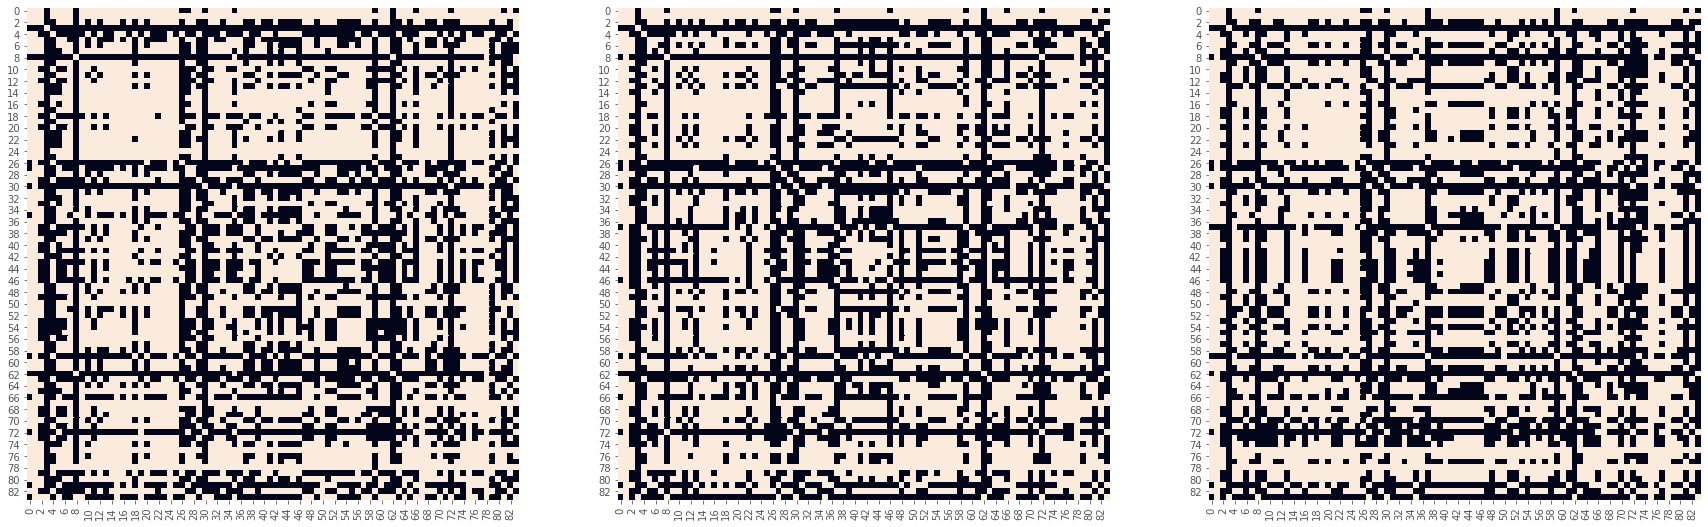

In [ ]:
lb = ['2019-01-01', '2019-05-01', '2019-10-01']
rb = ['2019-01-31', '2019-05-31', '2019-10-31']

fs = 10
fig, ax = plt.subplots(ncols = len(lb), figsize=( len(lb) * fs, fs))

tc_2019 = pd.DataFrame([courts_met]).transpose()
tc_2019.rename(columns={0 : 'Court'}, inplace=True)

for i in range(len(lb)) :
    pairwise_hypothesis_test_courts(lb[i], rb[i], tc_2019, alpha=0.1, axi=ax[i])

plt.savefig('/content/drive/MyDrive/НУЛ АДП Материалы Марии Тимониной/_Colab Notebooks НУЛ АДП/pics/матрицы2019.jpg')

tc_2019.set_index('Court', inplace=True)
tc_2019.agg(['max', 'min', q25, q75, 'mean'])

In [ ]:
tc_2019['Cname'] = tc_2019.index
tc_2019['Cname'] = tc_2019['Cname'].map(ic_cname)

In [ ]:
tc_2019.sort_values(by='2019-05-01', ascending=True, inplace=True)
tc_2019[:10]

,2019-01-01,2019-05-01,2019-10-01,Cname
Court,,,,
4,2,2,2,АС Амурской области
64,5,2,3,АС Тамбовской области
9,5,5,7,АС Брянской области
74,12,7,13,АС Республики Хакасия
32,6,8,9,АС Краснодарского края
28,26,12,17,АС Кировской области
90,34,13,11,ПСП Арбитражного суда Пермского края
27,18,14,24,АС Кемеровской области
48,34,17,50,АС Орловской области


,2017-01-01,2017-05-01,2017-10-01
max,83.000000,81.000000,81.000000
min,3.000000,5.000000,4.000000
q25,32.750000,34.750000,31.500000
q75,54.500000,58.000000,59.250000
mean,44.333333,45.857143,45.738095


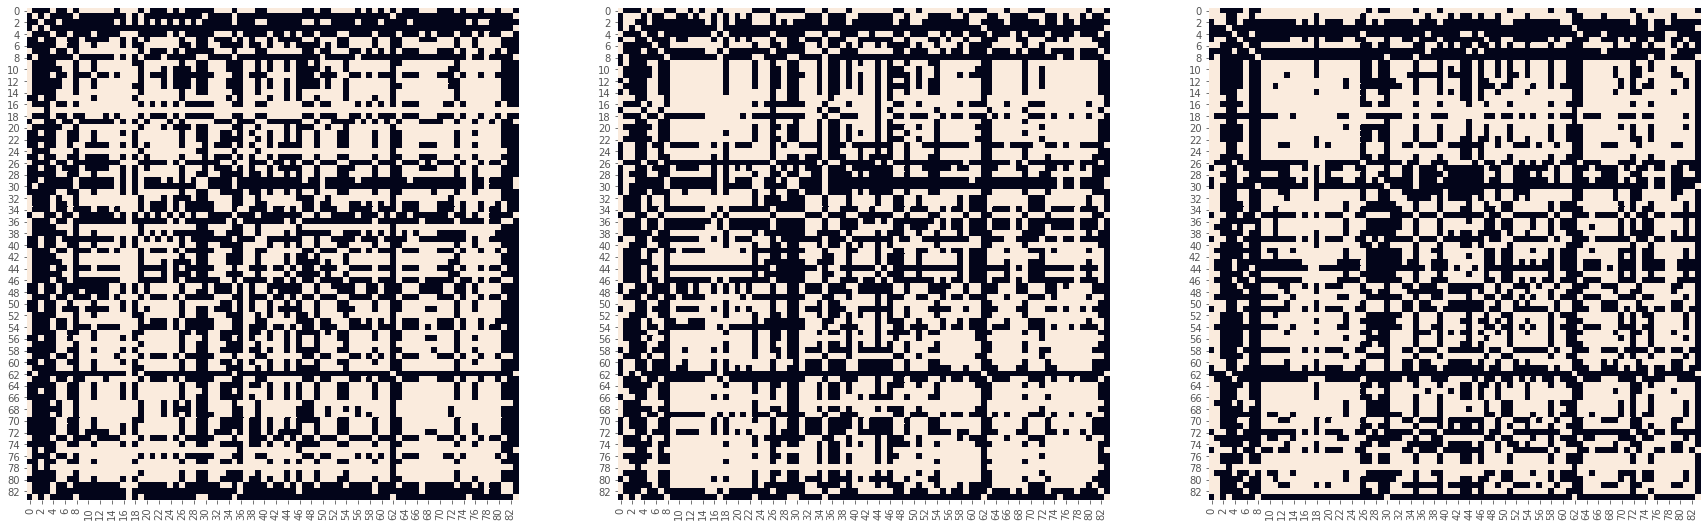

In [ ]:
lb = ['2017-01-01', '2017-05-01', '2017-10-01']
rb = ['2017-01-31', '2017-05-31', '2017-10-31']

fs = 10
fig, ax = plt.subplots(ncols = len(lb), figsize=( len(lb) * fs, fs))

tc_2017 = pd.DataFrame([courts_met]).transpose()
tc_2017.rename(columns={0 : 'Court'}, inplace=True)

for i in range(len(lb)) :
    pairwise_hypothesis_test_courts(lb[i], rb[i], tc_2017, alpha=0.1, axi=ax[i])

tc_2017.set_index('Court', inplace=True)
tc_2017.agg(['max', 'min', q25, q75, 'mean'])

In [ ]:
tc_2017['Cname'] = tc_2017.index
tc_2017['Cname'] = tc_2017['Cname'].map(ic_cname)

tc_2017.sort_values(by='2017-05-01', ascending=True, inplace=True)
tc_2017[:10]

,2017-01-01,2017-05-01,2017-10-01,Cname
Court,,,,
4,3,5,4,АС Амурской области
64,6,5,4,АС Тамбовской области
90,11,11,7,ПСП Арбитражного суда Пермского края
32,12,11,8,АС Краснодарского края
9,14,11,7,АС Брянской области
27,27,14,26,АС Кемеровской области
46,30,14,18,АС Омской области
31,18,15,23,АС Костромской области
38,16,22,51,АС Республики Марий Эл


,2015-01-01,2015-05-01,2015-10-01
max,81.000000,76.000000,70.000000
min,5.000000,4.000000,4.000000
q25,36.000000,32.750000,35.000000
q75,50.250000,57.000000,53.250000
mean,43.190476,45.190476,42.404762


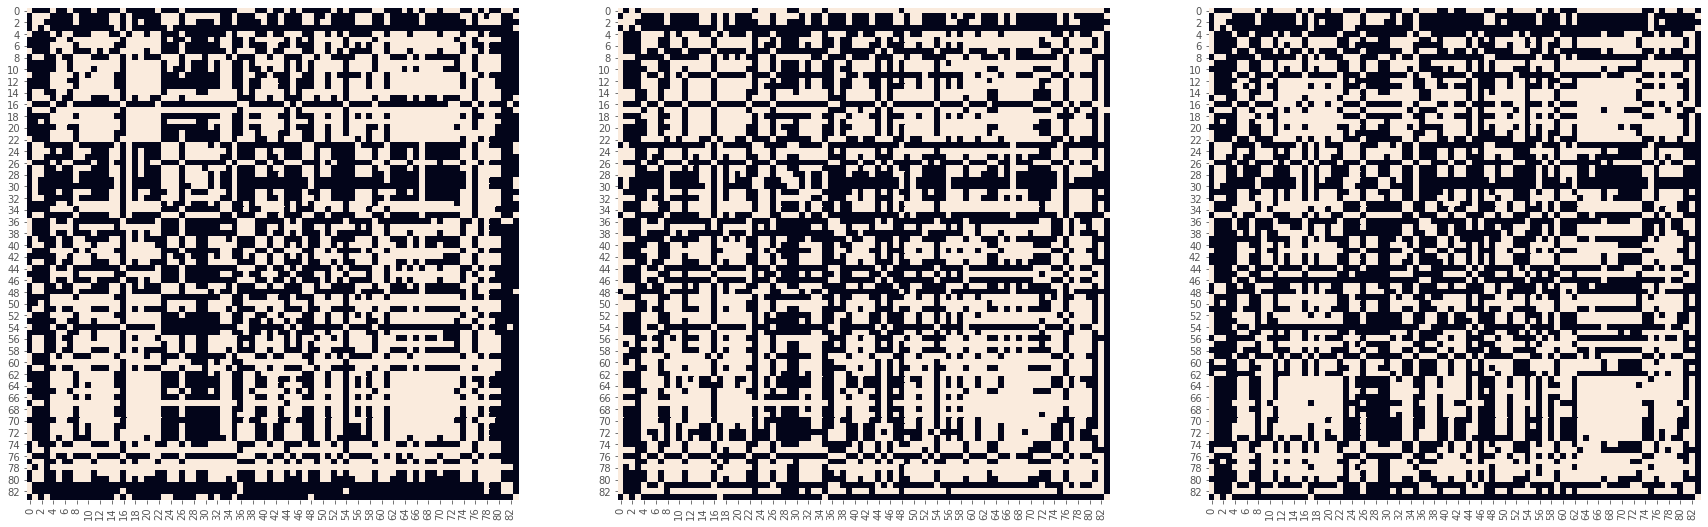

In [ ]:
lb = ['2015-01-01', '2015-05-01', '2015-10-01']
rb = ['2015-01-31', '2015-05-31', '2015-10-31']

fs = 10
fig, ax = plt.subplots(ncols = len(lb), figsize=( len(lb) * fs, fs))

tc_2015 = pd.DataFrame([courts_met]).transpose()
tc_2015.rename(columns={0 : 'Court'}, inplace=True)

for i in range(len(lb)) :
    pairwise_hypothesis_test_courts(lb[i], rb[i], tc_2015, alpha=0.1, axi=ax[i])

tc_2015.set_index('Court', inplace=True)
tc_2015.agg(['max', 'min', q25, q75, 'mean'])

In [ ]:
tc_2015['Cname'] = tc_2015.index
tc_2015['Cname'] = tc_2015['Cname'].map(ic_cname)

tc_2015.sort_values(by='2015-05-01', ascending=True, inplace=True)
tc_2015[:10]

,2015-01-01,2015-05-01,2015-10-01,Cname
Court,,,,
4,6,4,8,АС Амурской области
90,12,5,4,ПСП Арбитражного суда Пермского края
24,23,11,20,АС Камчатского края
32,17,15,12,АС Краснодарского края
83,5,15,19,АС Республики Крым
56,14,17,13,АС города Санкт-Петербурга и Ленинградской обл...
38,21,18,19,АС Республики Марий Эл
48,32,19,13,АС Орловской области
31,20,19,18,АС Костромской области
